In [1]:
import numpy as np
import sys
import re
import os
import cygnus_lib as cy
import toolslib as tl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
#import mylib as my
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line, resize, rescale)
import scipy.ndimage
from skimage.transform import hough_circle, hough_circle_peaks
from scipy.stats import norm
import scipy.stats as stats
from iDBSCAN import iDBSCAN


import pandas as pd
import pickle
import time
from IPython import display

%matplotlib inline
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
plt.rcParams['font.serif'] = ['Bitstream Vera Sans']
x_resolution = y_resolution = 2048
from itertools import combinations

In [7]:
t0 = time.time()

cy.set_atlas_style('large')
############# Data in imput #######################################
dataSelection = 'LAB'
#dataSelection = 'FNG'

#runI = [494, 492, 493]
runI = [494]
#runI = [813,814]

debug  = False
files = ""
################ analysis cards ################################
nsigma       = 1         # numero di sigma sopra il piedistallo
cimax        = 200       # valori del cut sull'imagine
iTr          = 0        # traccia di partenza
rescale      = 512       # binnagio finale immagine (deve essre un sottomultipli della 2**2 risluzione di partenza)
minClose     = 2         # minimum cluser size (rebinne image)
eps          = 5         # maximum distance for the cluster point
maxClose     = 30000     # massima dimesione del clustr evita le scriche      
Cmethod      = 'idbsc'    #'hdbs' # 'nccs' # 'dbsc' # 'idbsc'
max_image_to_read = 30  # 0 all
############### Inzializzazione varibili e costanti #################
scale        = int(x_resolution/rescale)



iterative    = 4         # number of iterations for the IDBSC
vector_eps = [2.26, 3.5, 2.8, 6]
vector_min_samples = [2, 35, 6, 2]
cuts = [900, 150]

flag_noise = False

# MAIN LOOP ON 


ievalclu = []
nevalclu = []

# - - - -
#lenL = np.zeros(tamX,tamY,dtype=float)
#lenM = np.zeros(tamX,tamY,dtype=float)
#lenS = np.zeros(tamX,tamY,dtype=float)

ini = 900 # 400
fin = 925
ste = 25
tam = (fin-ini)/ste

for cut1 in range(ini,fin,ste):
    cuts[0] = cut1
    data    = [] # output data
    print ("Analyzing Cut %d - %d%% completed...\n" % (cut1,np.round((((cut1-ini)/ste)*100)/tam)))
    for nRi in range(0,len(runI)):

        max_image=np.size(cy.swift_listdir(cy.file2FullPathCygnus(dataSelection, runI[nRi], 'H5')))
        print ("# of Image Files: %d" % (max_image))
        if max_image_to_read != 0:
            max_image = max_image_to_read   
        print ("WARNING: data will be anlyzed from %d to %d" % (iTr, max_image))

        if max_image == 0:
            print ("No file or image for file %s" % runI[nRi])
            print ("STOP")
            break

        #
        # load pedestal value generated by runs-pedestals.ipynb script
        # 
        try:
            fileoutm = ("./data/run%d_mean.h5" % (runI[nRi]))
            m_image = cy.read_image_h5(fileoutm)
            PedOverMax = m_image[m_image > cimax].size
            print ("Pedestal mean: %.2f, sigma: %.2f, over th. (%d) %d" % 
               (m_image[m_image<cimax].mean(), 
                np.sqrt(m_image[m_image<cimax].var()), cimax,
                (m_image>cimax).sum()))
        except:
            print ("No Pedestal file for run %s, run script runs-pedestals.ipynb" % runI[nRi])
            print ("STOP")
            break
        try: 
            fileouts = ("./data/run%d_sigma.h5" % (runI[nRi]))
            s_image = cy.read_image_h5(fileouts)
            print ("Sigma mean: %.2f, sigma: %.2f, over th. (50) %d" % 
           (s_image[s_image<50].mean(), 
            np.sqrt(s_image[s_image<50].var()), 
            (s_image>50).sum()))
        except:
            print ("No Sigma file for run %s, run script runs-pedestals.ipynb" % runI[nRi])
            print ("STOP")
            break

        #
        # Run by run init 
        #
        th_image   = np.round(m_image + nsigma*s_image) # verficare con il np.round.... np.ceil
        # th_image[:,:]=101 # per imostare tutto a 101

        TrOk   = 0
        dCloseT= 0
        
        if flag_noise == True:
            nCluT = 0
            nNoiT = 0
        else:
            nCluF = 0
            nNoiF = 0
        
        #################################
        # MAIN LOOP ON RUN
        ##################################

        for iTr in range(0, max_image):
            # load image
            image = cy.swift_read_image_h5(cy.imageFile2FullPathCygnus(dataSelection, runI[nRi], iTr)) 

            if (np.sum(image)/np.sum(m_image)) < 1.09: # Avoid wrong images 1.02 with we want to skip sparks too
                if image[image> cimax].size<1000000: # limit on the number og pixel over high cutof
                    TrOk += 1
                    print ("Analyzing Run %d Image %d \n" % (runI[nRi],iTr))
                    print ("SumLight/SumPedestal = %.4f" % (np.sum(image)/np.sum(m_image)))

                    edges_image     = (image > th_image) & (image < cimax)
                    rebin_image     = cy.rebin(image, (rescale, rescale))
                    rebin_th_image  = cy.rebin(th_image, (rescale, rescale))
                    edges           = (rebin_image > rebin_th_image) & (rebin_image < cimax)         
                    points          = np.array(np.nonzero(edges)).T.astype(float)

                    #clusters = iDBSCAN(iterative).fit(points)
                    clusters = iDBSCAN(iterative = iterative, vector_eps = vector_eps, vector_min_samples = vector_min_samples, cuts = cuts, flag_noise = flag_noise).fit(points)
    #                 naive = iDBSCAN(iterative = 0).fit(points)

                    n_clusters_ = len(set(clusters.labels_)) - (1 if -1 in clusters.labels_ else 0)
                    n_noise_ = list(clusters.labels_).count(-1)
                    
                    if flag_noise == True:
                        nCluT = nCluT + n_clusters_
                        nNoiT = nNoiT + n_noise_
                    else:
                        nCluF = nCluF + n_clusters_
                        nNoiF = nNoiF + n_noise_

                    # - - - - 

                    #lenL = np.size(clusters.tag_[clusters.tag_ == 'l'])
                    #lenM = np.size(clusters.tag_[clusters.tag_ == 'm'])
                    #lenS = np.size(clusters.tag_[clusters.tag_ == 's'])

                    # - - - - 

                    # - - - - Cluster Evaluation - - - - #
    #                 idb_sco   = [] # cluster info idb
    #                 ndb_sco   = [] # cluster info ndb
    #                 isco_db, isco_ch, isco_sh = evaluation_scores(points, clusters.labels_)
    #                 nsco_db, nsco_ch, nsco_sh = evaluation_scores(points, naive.labels_)
    #                 idb_sco.append(runI[nRi])
    #                 idb_sco.append(iTr)
    #                 idb_sco.append(isco_db)
    #                 idb_sco.append(isco_ch)
    #                 idb_sco.append(isco_sh)
    #                 ievalclu.append(idb_sco)

    #                 ndb_sco.append(runI[nRi])
    #                 ndb_sco.append(iTr)
    #                 ndb_sco.append(nsco_db)
    #                 ndb_sco.append(nsco_ch)
    #                 ndb_sco.append(nsco_sh)
    #                 nevalclu.append(ndb_sco)

                    for Ci in range (0, n_clusters_): # number of clusters found in the image
                        cluvar   = [] # cluster info
                        #print ("Salving cluster %d from %d" % (Ci,n_clusters_))
                        Xi, Yi, Is, Ib, tag = tl.cluInfo(clusters,points,Ci,image,th_image,scale) # extract cluster information
                        # cluvar = [Run, Imag, Tag, X position, Y position, Light signal, Light pedestal]
                        cluvar.append(runI[nRi])
                        cluvar.append(iTr)
                        cluvar.append(tag)
                        cluvar.append(Xi)
                        cluvar.append(Yi)
                        cluvar.append(Is)
                        cluvar.append(Ib)
                        data.append(cluvar) # save the cluster info in a List
            print ("...Next image... \n")
    t1 = time.time()
    print ("Elapsed time of the algorithm: %.2f seconds / %.2f minutes" % ((t1-t0),(t1-t0)/60))
    
#     #------------------- Saving File ------------------------------#
#     directory = ("./data/")          # Directory of the output file
#     filename  = ("ClustersTable_I%d_Cut%d_E%f_M%d" % (iterative,cut1,vector_eps[iterative],vector_min_samples[iterative]))    # Name of the output file
#     extension = (".csv")             # Extension of the output file
#     dataout = directory + filename + extension # Full path of the output file

#     columns = ["Run","Image","Tag","X","Y","Light","Pedestal"]
#     df = pd.DataFrame(data, columns = columns)

#     #Now you have a csv with columns and index:
#     df.to_csv(dataout,index=False)

Analyzing Cut 900 - 0% completed...

# of Image Files: 300
Pedestal mean: 99.63, sigma: 2.02, over th. (200) 1955


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in less
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in less
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in greater


Sigma mean: 3.23, sigma: 2.23, over th. (50) 2208
Analyzing Run 494 Image 0 

SumLight/SumPedestal = 0.9955


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in greater
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in greater


...Next image... 

Analyzing Run 494 Image 1 

SumLight/SumPedestal = 0.9973


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in greater
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in greater


...Next image... 

Analyzing Run 494 Image 2 

SumLight/SumPedestal = 0.9965


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in greater
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in greater


...Next image... 

Analyzing Run 494 Image 3 

SumLight/SumPedestal = 0.9953


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in greater
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in greater


...Next image... 

Analyzing Run 494 Image 4 

SumLight/SumPedestal = 0.9954


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in greater
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in greater


...Next image... 

Analyzing Run 494 Image 5 

SumLight/SumPedestal = 0.9957


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in greater
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in greater


...Next image... 

Analyzing Run 494 Image 6 

SumLight/SumPedestal = 0.9961


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in greater
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in greater


...Next image... 

Analyzing Run 494 Image 7 

SumLight/SumPedestal = 0.9943


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in greater
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in greater


...Next image... 

Analyzing Run 494 Image 8 

SumLight/SumPedestal = 0.9959


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in greater
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in greater


...Next image... 

Analyzing Run 494 Image 9 

SumLight/SumPedestal = 0.9952


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in greater
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in greater


...Next image... 

Analyzing Run 494 Image 10 

SumLight/SumPedestal = 0.9966


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in greater
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in greater


...Next image... 

Analyzing Run 494 Image 11 

SumLight/SumPedestal = 0.9948


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in greater
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in greater


...Next image... 

Analyzing Run 494 Image 12 

SumLight/SumPedestal = 0.9970


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in greater
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in greater


...Next image... 

Analyzing Run 494 Image 13 

SumLight/SumPedestal = 0.9955


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in greater
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in greater


...Next image... 

Analyzing Run 494 Image 14 

SumLight/SumPedestal = 0.9962


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in greater
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in greater


...Next image... 

Analyzing Run 494 Image 15 

SumLight/SumPedestal = 0.9948


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in greater
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in greater


...Next image... 

Analyzing Run 494 Image 16 

SumLight/SumPedestal = 0.9970


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in greater
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in greater


...Next image... 

Analyzing Run 494 Image 17 

SumLight/SumPedestal = 0.9966


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in greater
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in greater


...Next image... 

Analyzing Run 494 Image 18 

SumLight/SumPedestal = 0.9957


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in greater
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in greater


...Next image... 

Analyzing Run 494 Image 19 

SumLight/SumPedestal = 0.9954


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in greater
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in greater


...Next image... 

Analyzing Run 494 Image 20 

SumLight/SumPedestal = 0.9966


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in greater
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in greater


...Next image... 

Analyzing Run 494 Image 21 

SumLight/SumPedestal = 0.9965


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in greater
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in greater


...Next image... 

Analyzing Run 494 Image 22 

SumLight/SumPedestal = 0.9962


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in greater
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in greater


...Next image... 

Analyzing Run 494 Image 23 

SumLight/SumPedestal = 0.9952


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in greater
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in greater


...Next image... 

Analyzing Run 494 Image 24 

SumLight/SumPedestal = 0.9975


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in greater
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in greater


...Next image... 

Analyzing Run 494 Image 25 

SumLight/SumPedestal = 0.9957


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in greater
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in greater


...Next image... 

Analyzing Run 494 Image 26 

SumLight/SumPedestal = 0.9959


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in greater
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in greater


...Next image... 

Analyzing Run 494 Image 27 

SumLight/SumPedestal = 0.9949


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in greater
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in greater


...Next image... 

Analyzing Run 494 Image 28 

SumLight/SumPedestal = 0.9967


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in greater
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in greater


...Next image... 

Analyzing Run 494 Image 29 

SumLight/SumPedestal = 0.9955


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in greater
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in greater


...Next image... 

Elapsed time of the algorithm: 102.89 seconds / 1.71 minutes


In [9]:
print("With noise rejection iteration")
print('Number of clusters: %d' % (nCluT))
print('Number of noise pixels: %d' % (nNoiT))
print('-------------------------------')
print("Without noise rejection iteration")
print('Number of clusters: %d' % (nCluF))
print('Number of noise pixels: %d' % (nNoiF))

With noise rejection iteration
Number of clusters: 2469
Number of noise pixels: 8148
-------------------------------
Without noise rejection iteration
Number of clusters: 2864
Number of noise pixels: 6256


In [17]:
nCluT/(nCluF)

0.8620810055865922

In [18]:
nNoiT/nNoiF

1.3024296675191815

In [3]:
t2 = time.time()
#------------------- Saving File ------------------------------#
directory = ("./data/")          # Directory of the output file
filename  = ("ClustersTable_")    # Name of the output file
extension = (".csv")             # Extension of the output file
dataout = directory + filename + extension # Full path of the output file

import pandas as pd

columns = ["Run","Image","Tag","X","Y","Light","Pedestal"]
df = pd.DataFrame(data, columns = columns)

#Now you have a csv with columns and index:
df.to_csv(dataout,index=False)

t3 = time.time()
print ("Table saving time: %.2f seconds / %.2f minutes" % ((t3-t2),(t3-t2)/60))

Table saving time: 148.19 seconds / 2.47 minutes


# Clustering performance evaluation

## Davies-Bouldin

Zero is the lowest possible score. Values closer to zero indicate a better partition.

## Calinski-Harabaz

The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster
    
## Silhouette

The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters.
The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.


In [48]:
import pandas as pd


columns = ["Run","Image","DaviesBouldin","CalinskiHarabaz","Silhouette"]
idf = pd.DataFrame(ievalclu, columns = columns)
ndf = pd.DataFrame(nevalclu, columns = columns)
idf.head(n=10)

Run  Image  DaviesBouldin  CalinskiHarabaz  Silhouette
0  494      0       1.717628       225.209592    0.393691
1  494      1       1.727819       189.977559   -0.125214
2  494      2       1.731366       358.033920    0.311590
3  494      3       1.637859       254.957817    0.375504
4  494      4       1.701902       133.215980    0.480195
5  494      5       2.617978       487.223415    0.440939
6  494      6       6.537419       289.245661    0.268382
7  494      7       1.542828        93.884793    0.269873
8  494      8       1.979626       202.199783    0.321764
9  494      9       1.514813       472.163542    0.444944

In [49]:
ndf.head(n=10)

Run  Image  DaviesBouldin  CalinskiHarabaz  Silhouette
0  494      0       1.718120       176.052816    0.379139
1  494      1       1.568948       117.746651   -0.148641
2  494      2       1.682086       264.155464    0.278460
3  494      3       1.536842       148.960204    0.351645
4  494      4       1.580924        81.585312    0.469559
5  494      5       2.471116       387.274788    0.418888
6  494      6       5.088453       205.745052    0.259734
7  494      7       1.583699        65.695618    0.276536
8  494      8       1.916132       128.129380    0.309123
9  494      9       1.516786       360.104474    0.359921

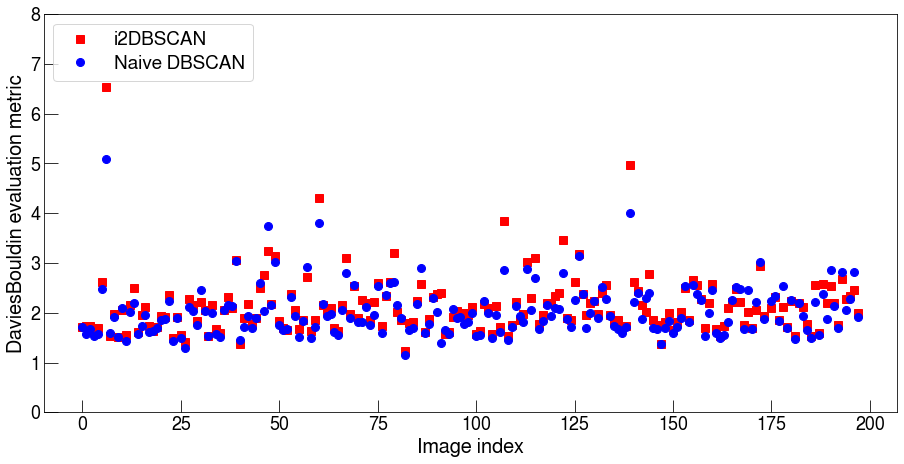

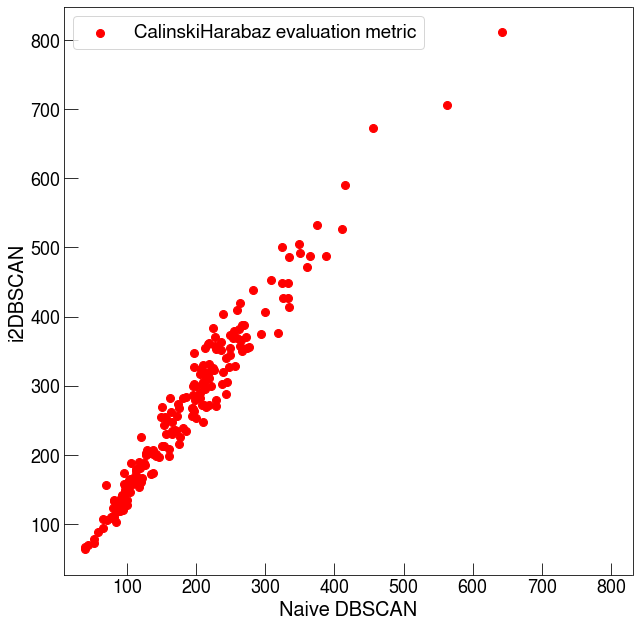

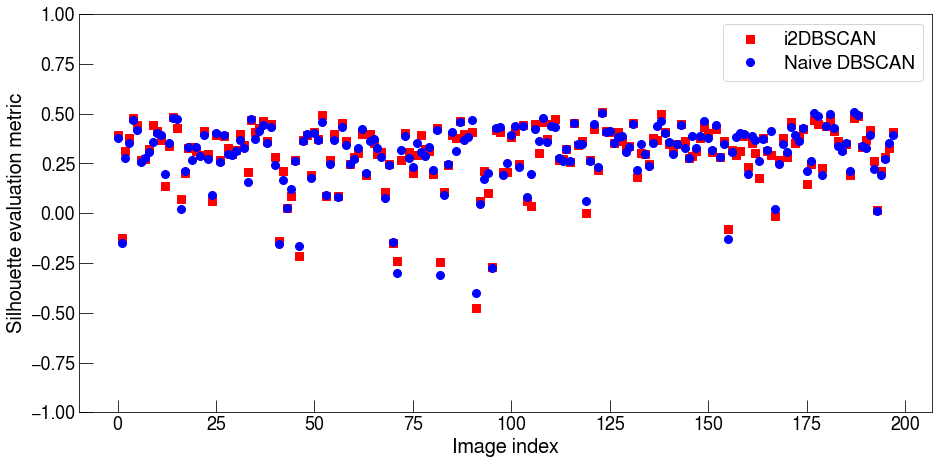

In [60]:
m=2

fig = plt.figure(figsize=(15,7))

plt.plot(idf.index, idf[columns[m]], 'rs')
plt.plot(ndf.index, ndf[columns[m]], 'bo')
    
plt.xlabel('Image index')
plt.ylabel(columns[m] + ' evaluation metric')
#plt.xlim([0,1850])
plt.ylim([0,8])

plt.legend(['i2DBSCAN','Naive DBSCAN'])
plt.show()

m=3

fig = plt.figure(figsize=(10,10))

plt.scatter(ndf[columns[m]], idf[columns[m]],c='r')
#plt.plot(ndf.index, ndf[columns[m]], 'bo')
plt.xlabel('Naive DBSCAN')
plt.ylabel('i2DBSCAN')

#plt.xlabel('Image index')
#plt.ylabel(columns[m] + ' evaluation metric')
#plt.xlim([0,1850])
#plt.ylim([0,800])
plt.axis('square')

plt.legend([columns[m] + ' evaluation metric'])
plt.show()

m=4

fig = plt.figure(figsize=(15,7))

plt.plot(idf.index, idf[columns[m]], 'rs')
plt.plot(ndf.index, ndf[columns[m]], 'bo')
    
plt.xlabel('Image index')
plt.ylabel(columns[m] + ' evaluation metric')
#plt.xlim([0,1850])
plt.ylim([-1,1])

plt.legend(['i2DBSCAN','Naive DBSCAN'])
plt.show()

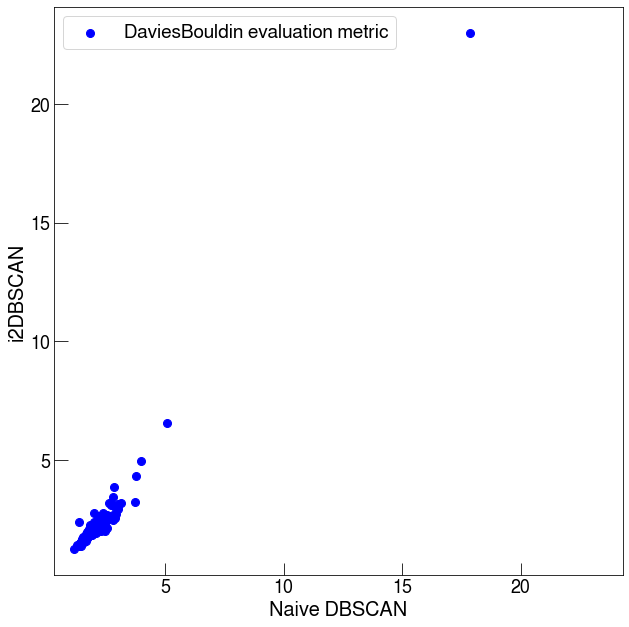

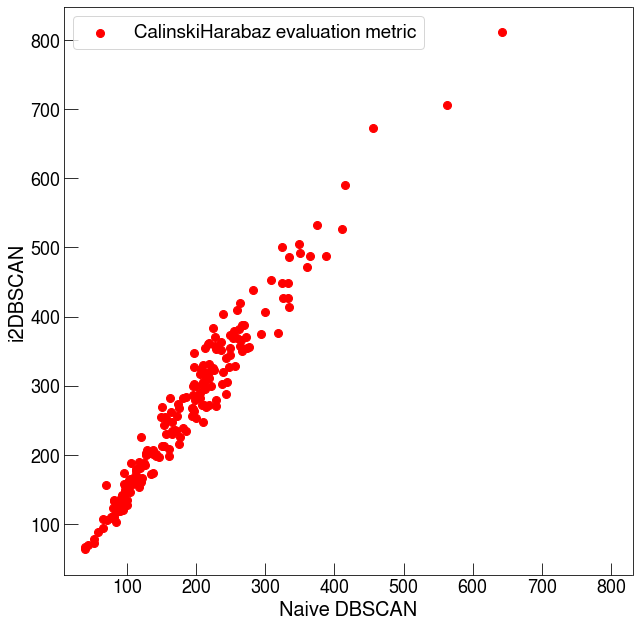

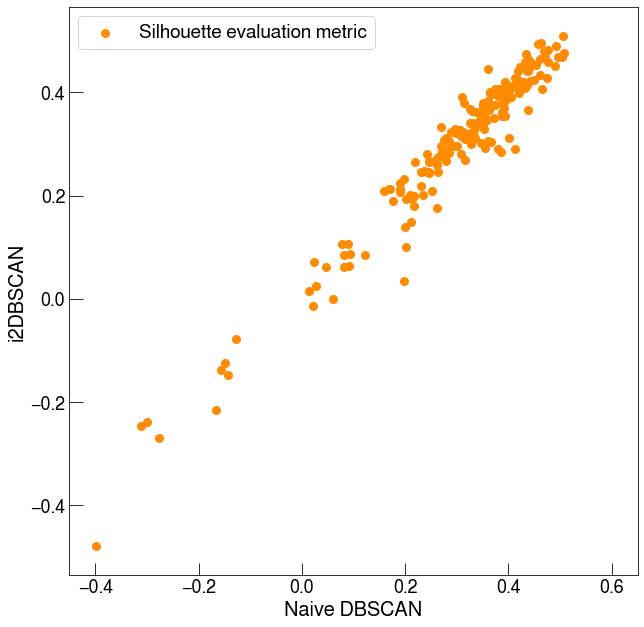

In [64]:
#m = 3
cc = ['b','r','darkorange']

for m in range(2,5):
    
    fig = plt.figure(figsize=(10,10))

    plt.scatter(ndf[columns[m]], idf[columns[m]],c=cc[m-2])
    #plt.plot(ndf.index, ndf[columns[m]], 'bo')
    plt.xlabel('Naive DBSCAN')
    plt.ylabel('i2DBSCAN')

    #plt.xlabel('Image index')
    #plt.ylabel(columns[m] + ' evaluation metric')
    #plt.xlim([1,5])
    #plt.ylim([1,5])
    plt.axis('square')

    plt.legend([columns[m] + ' evaluation metric'])
    plt.show()

In [27]:
def evaluation_scores(points, labels):

    from sklearn.metrics import davies_bouldin_score
    from sklearn.metrics import calinski_harabaz_score
    from sklearn.metrics import silhouette_score

    sco_db = davies_bouldin_score(points, labels)
    sco_ch = calinski_harabaz_score(points, labels)
    sco_sh = silhouette_score(points, labels, metric='euclidean')
    
    return sco_db, sco_ch, sco_sh